In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# Prepare label sequences for training function
def shift_elements(arr, num, fill_value):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

# example show the process
data = np.array([
 [1, 2, 3], [4, 5, 6]   
]
)

sh_data = data.copy()

for i in range(0, 2):
    sh_data[i] = shift_elements(data[i], 1, 0)

print(data)
print('------------------')
print(sh_data)

[[1 2 3]
 [4 5 6]]
------------------
[[0 1 2]
 [0 4 5]]


In [3]:
input_addr = "E:\\AI\\Grammar project\\dataset\\input_vector.csv"
labels_addr = "E:\\AI\\Grammar project\\dataset\\labels_vector.csv"

In [4]:
df_x = pd.read_csv(input_addr, sep=',', header=None)

In [5]:
df_x.values.shape

(3000000, 50)

In [6]:
x = df_x.values

In [7]:
x

array([[    0,     0,     0, ...,    11,     2,   521],
       [  171,    19,   658, ...,  1755,    20,   341],
       [    0,     0,     0, ...,     6,     2,   267],
       ...,
       [    0,     0,     0, ...,     4, 10287,  1285],
       [    0,     0,     0, ...,    76,  2402,  2067],
       [    0,     0,     0, ...,     5,   441,   255]], dtype=int64)

In [8]:
df_y = pd.read_csv(labels_addr, sep=',', header=None)

In [9]:
df_y.values.shape

(3000000, 50)

In [10]:
y = df_y.values

In [11]:
y

array([[    0,     0,     0, ...,    11,     2,   521],
       [  658,     8,   509, ...,  1755,    20,   341],
       [    0,     0,     0, ...,     6,     2,   267],
       ...,
       [    0,     0,     0, ...,     4, 10287,  1285],
       [    0,     0,     0, ...,     7,  2402,  2067],
       [    0,     0,     0, ...,     5,   441,   255]], dtype=int64)

In [12]:
train_percentage = 0.85
test_percentage = 0.15
train_size = int(train_percentage * 3000000)

print(f'train ends at: {train_size}')

train ends at: 2550000


In [13]:
x_train = x[0: train_size]
y_train = y[0: train_size]

x_test = x[train_size:]
y_test = y[train_size:]

In [14]:
x_train.shape , x_test.shape

((2550000, 50), (450000, 50))

In [15]:
#normalize data
num_tokens = 5855332 #[0:5855332]

x_train = x_train / num_tokens
y_train = y_train / num_tokens

x_test = x_test / num_tokens
y_test = y_test / num_tokens

In [16]:
# prepare decoder inputs
dec_in = y_train.copy()

for i in range(0, 2550000):
    dec_in[i] = shift_elements(dec_in[i], 1, 0)

In [17]:
y_train, dec_in

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.87862960e-06, 3.41569018e-07, 8.89787291e-05],
        [1.12376207e-04, 1.36627607e-06, 8.69293150e-05, ...,
         2.99726813e-04, 3.41569018e-06, 5.82375175e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.02470705e-06, 3.41569018e-07, 4.55994639e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.19890725e-04, 3.17659187e-05, 2.55459468e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.02470705e-06, 2.64886773e-04, 1.21257001e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.31902683e-06, 8.32062127e-04, 1.89400020e-04]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.70272155e-03, 1.87862960e-06, 3.41569018e-07],
        [0.00000000e+00, 1.12376207e-04, 1.36627607e-06, ...,
         7.27542008e-05, 2.99726813e-04, 3.41569018e-06],
        [0.00000000e+00, 

In [18]:
x_train = np.reshape(x_train, ((2550000, 1,50)))
y_train = np.reshape(y_train, ((2550000, 1,50)))
dec_in = np.reshape(dec_in, ((2550000, 1,50)))

# Making the model

In [18]:
from numpy import array
from numpy import argmax
from numpy import array_equal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [67]:
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(1, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # define training decoder
    decoder_inputs = Input(shape=(1, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='sigmoid')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # The training model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # For predicting 
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    # return all models
    return model, encoder_model, decoder_model

In [30]:
train_model, enc_model, dec_model = define_models(50, 50, 512)

In [31]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 50)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 50)        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 512), (None, 1153024     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 1, 512), (No 1153024     input_2[0][0]                    
                                                                 lstm[0][1]                       
          

In [32]:
enc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 50)             0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1153024   
Total params: 1,153,024
Trainable params: 1,153,024
Non-trainable params: 0
_________________________________________________________________


In [33]:
dec_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 50)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 1, 512), (No 1153024     input_2[0][0]                    
                                                                 input_3[0][0]                    
          

# Visualize models

In [4]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [5]:
# These images are made with th help of keras functions
enc_img = load_img("E:\\AI\\Grammar project last version\\Visualize Models\\encoder model.jpg")
dec_img = load_img("E:\\AI\\Grammar project last version\\Visualize Models\\decoder model.jpg")
train_img = load_img("E:\\AI\\Grammar project last version\\Visualize Models\\training model.jpg")

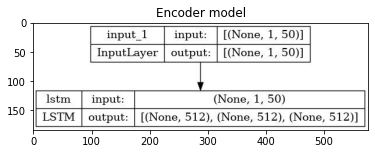

In [7]:
plt.imshow(enc_img)
plt.title("Encoder model")
plt.show() # display

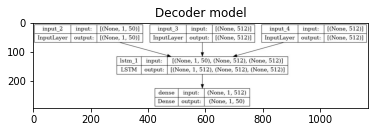

In [8]:
plt.imshow(dec_img)
plt.title("Decoder model")
plt.show() # display

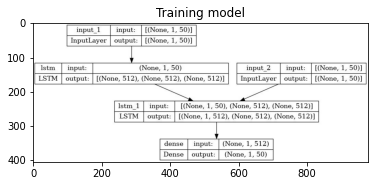

In [9]:
plt.imshow(train_img)
plt.title("Training model")
plt.show() # display

# Training the encoder decoder model

In [36]:
train_model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',])

In [37]:
train_model.fit([x_train, dec_in], y_train,
          epochs=1,
         batch_size = 100)

Epoch 1/1
2550000/2550000 [==============================] - 1059s 415us/step - loss: 0.0933 - acc: 0.5042


In [38]:
train_model.fit([x_train, dec_in], y_train,
          epochs=2,
         batch_size = 100)

Epoch 1/2
2550000/2550000 [==============================] - 1058s 415us/step - loss: 0.0860 - acc: 0.6522
Epoch 2/2
2550000/2550000 [==============================] - 1069s 419us/step - loss: 0.0846 - acc: 0.7008


In [19]:
# for evaluation process
dec_in_test = y_test.copy()

for i in range(0, 450000):
    dec_in_test[i] = shift_elements(dec_in_test[i], 1, 0)

x_test = np.reshape(x_test, ((450000, 1,50)))
y_test = np.reshape(y_test, ((450000, 1,50)))
dec_in_test = np.reshape(dec_in_test, ((450000, 1,50)))

In [40]:
val_loss, val_acc = train_model.evaluate([x_test, dec_in_test], y_test)

450000/450000 [==============================] - 73s 162us/step


In [41]:
val_loss, val_acc

(0.0883720545689265, 0.7243244444444444)

In [42]:
train_model.fit([x_train, dec_in], y_train,
          epochs=1,
         batch_size = 100)

Epoch 1/1
2550000/2550000 [==============================] - 1072s 421us/step - loss: 0.0838 - acc: 0.7266


In [43]:
val_loss, val_acc = train_model.evaluate([x_test, dec_in_test], y_test)

450000/450000 [==============================] - 73s 162us/step


In [44]:
val_loss, val_acc

(0.08782512504312727, 0.7140044444444444)

In [45]:
#saving the model
train_model.save('E:\\AI\\Grammar project\\new_model\\grammar_model.model')

In [133]:
#saving the encoder
enc_model.save('E:\\AI\\Grammar project\\new_model\\grammar_model_encoder.model')

#saving the decoder
dec_model.save('E:\\AI\\Grammar project\\new_model\\grammar_model_decoder.model')

# The process of prediction

In [ ]:
enc_model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',])

In [121]:
dec_model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',])